In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

# Prepare slidelist DataFrame
base_dir = "./viewer_latency_data"
slidelist_path = os.path.join(base_dir, "slidelist.csv")
slidelist = pd.read_csv(slidelist_path)
slidelist['quality'] = slidelist['quality'].replace({'Med': 'Medium'})
slidelist['slide_number'] = (slidelist.index // 9) + 1

# Read the CSV files and prepare the DataFrame
all_data = []
for idx, row in slidelist.iterrows():
    csv_path = os.path.join(base_dir, row['csv_file'])
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        for col in ['quality', 'layers', 'size', 'imaging_time', 'whole_time', 'slide_number']:
            df[col] = row[col]
        all_data.append(df)
    else:
        print(f"Missing: {csv_path}")

full_df = pd.concat(all_data, ignore_index=True)
full_df['quality'] = full_df['quality'].astype('category')
full_df['layers'] = full_df['layers'].astype('category')
full_df['level'] = full_df['level'].astype('category')


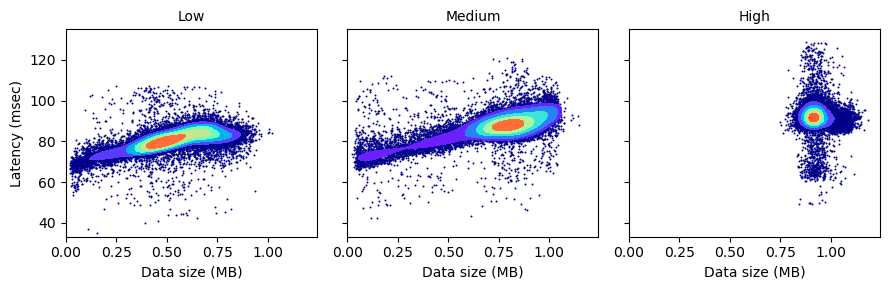

In [2]:
# Font setting
mpl.rcParams['font.family'] = 'DejaVu Sans' 

# Dataframe preparation
quality_order = ['Low', 'Medium', 'High']
full_df['quality'] = pd.Categorical(full_df['quality'], categories=quality_order, ordered=True)
full_df['slide_number'] = full_df['slide_number'].astype(str)
full_df['level'] = full_df['level'].astype(str)
filtered_df = full_df[(full_df['level'] == '17')].copy()
filtered_df = filtered_df.dropna(subset=['Average Content Size', 'Median Response Time'])
filtered_df['Average Content Size (MB)'] = filtered_df['Average Content Size'] / 1e6

# FacetGrid
g = sns.FacetGrid(
    filtered_df,
    col='quality',
    col_order=quality_order,
    margin_titles=True,
    despine=False,
    height=3,
    aspect=1.0
)

# Scatter plot for each quality (bottom layer)
g.map_dataframe(
    sns.scatterplot,
    x='Average Content Size (MB)',
    y='Median Response Time',
    s=2,
    linewidth=0,
    color='darkblue'
)

# KDE plot for each quality (top layer)
g.map_dataframe(
    sns.kdeplot,
    x='Average Content Size (MB)',
    y='Median Response Time',
    fill=True,
    cmap='rainbow',
    levels=6,
    thresh=0.3
)

# Set axis limits
x_min = filtered_df['Average Content Size (MB)'].min()
x_max = filtered_df['Average Content Size (MB)'].max()
y_min = filtered_df['Median Response Time'].min()
y_max = filtered_df['Median Response Time'].max()
for ax in g.axes.flatten():
    ax.set_xlim(0, x_max*1.05)
    ax.set_ylim(y_min*0.95, y_max*1.05)

# ラベルの整形
g.set_axis_labels('Data size (MB)', 'Latency (msec)')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()
